# Trying VGG pretrained model

In [1]:
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
import cv2 as cv2 # opencv computer vision library
from PIL import Image
import os
import sys

dirname = os.path.abspath(os.path.join(os.getcwd(), "..", "lib"))
sys.path.append(dirname)

from display import imshow

## Construct the model

### Load images

array([[<Axes: >]], dtype=object)

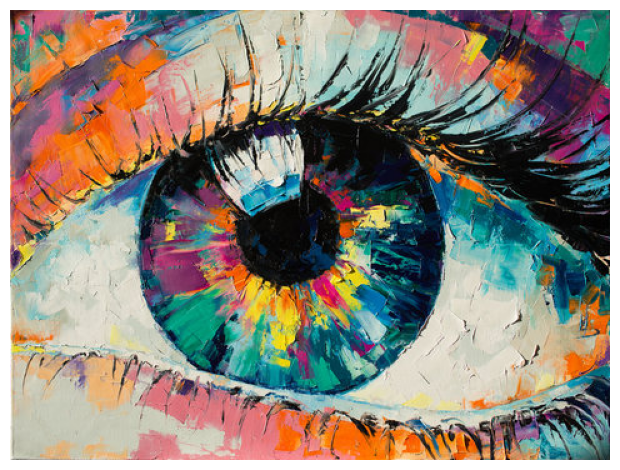

In [2]:
eye_style = Image.open("../data/style/eye.jpg")
imshow(eye_style)

### Normalize and preprocess the image

In [3]:
# Define normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std =[0.229, 0.224, 0.225])
def preprocess(image, device=None):
    if device==None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Assume 'image' is a PIL Image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize
    ])
    return transform(image)#.unsqueeze(0).to(device)  # Add batch dimension

def deprocess(tensor):
    # Denormalize and convert tensor to PIL Image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std =[1/0.229, 1/0.224, 1/0.225]
    )
    tensor = inv_normalize(tensor.squeeze(0).cpu())
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

In [4]:
eye_style_tensor = preprocess(eye_style)

### Surgery on the model to extract features

In [5]:

class VGGFeatures(nn.Module):
    def __init__(self, layers=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'], device=None):
        super(VGGFeatures, self).__init__()
        if device==None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()
        self.layers = layers
        self.layer_name_mapping = {
            '1': "relu1_1",
            '3': "relu1_2",
            '6': "relu2_1",
            '8': "relu2_2",
            '11': "relu3_1",
            '13': "relu3_2",
            '15': "relu3_3",
            '17': "relu3_4",
            '20': "relu4_1",
            '22': "relu4_2",
            '24': "relu4_3",
            '26': "relu4_4",
            '29': "relu5_1",
            '31': "relu5_2",
            '33': "relu5_3",
            '35': "relu5_4",
        }

    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layer_name_mapping:
                layer_name = self.layer_name_mapping[name]
                if layer_name in self.layers:
                    features[layer_name] = x
            if len(features) == len(self.layers):
                break
        return features


In [6]:
vgg_features = VGGFeatures()

/home/acepeax/Desktop/Studies/CSC/Vision/DeepStyleX/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/acepeax/Desktop/Studies/CSC/Vision/DeepStyleX/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
features = vgg_features(eye_style_tensor)

In [8]:
features.keys()

dict_keys(['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])

In [9]:
for feature in features.keys():
    print(feature,':',features[feature].shape)

relu1_2 : torch.Size([64, 256, 256])
relu2_2 : torch.Size([128, 128, 128])
relu3_3 : torch.Size([256, 64, 64])
relu4_3 : torch.Size([512, 32, 32])
relu5_3 : torch.Size([512, 16, 16])


We have 5 features with vgg19, and each features is a 3-dimensional vector.

Now this code had been added to `lib/vgg.py` to easily import this VGG class, and `lib/utils.py` to preprocess and deprocess the images.